In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils, callbacks, preprocessing

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


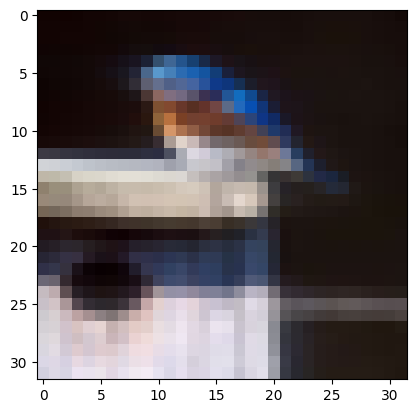

In [2]:
tf.random.set_seed(42)

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
plt.imshow(X_train[13]) 

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=13)

X_train, X_test, X_valid = X_train / 255.0, X_test / 255.0, X_valid / 255.0

y_train, y_test, y_valid = [utils.to_categorical(y, num_classes=10) for y in (y_train, y_test, y_valid)]

dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.shuffle(500).batch(256).prefetch(AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(AUTOTUNE)
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(AUTOTUNE)

print(tf.config.experimental.list_physical_devices('GPU'))


In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = models.Sequential()

# Adding Convolutional Layers with Batch Normalization and MaxPooling
filters = [32, 64, 128]
for f in filters:
    model.add(Conv2D(filters=f, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=f, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

# Flattening the output for the Dense layers
model.add(Flatten())

# Adding Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [4]:
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

In [5]:
lr_reduction = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-4)
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=4)
tensorboard_callback = callbacks.TensorBoard(log_dir="models/exp2_logs")

# Fit the model
history = model.fit(dataset_train, epochs=50, validation_data=dataset_valid, callbacks=[lr_reduction, early_stopping, tensorboard_callback])

# Evaluation
evaluation_metrics = model.evaluate(dataset_test)
print(f"Eval_loss = {evaluation_metrics[0]} \nEval_accuracy = {evaluation_metrics[1]} \nEval_precision = {evaluation_metrics[2]} \nEval_recall = {evaluation_metrics[3]}")


Epoch 1/50
196/196 [==============================] - 4s 15ms/step - loss: 1.7016 - accuracy: 0.4018 - precision: 0.5946 - recall: 0.1923 - val_loss: 3.6619 - val_accuracy: 0.1050 - val_precision: 0.1135 - val_recall: 0.0898 - lr: 0.0010
Epoch 2/50
196/196 [==============================] - 3s 13ms/step - loss: 1.2251 - accuracy: 0.5629 - precision: 0.7191 - recall: 0.4021 - val_loss: 2.2582 - val_accuracy: 0.3504 - val_precision: 0.5066 - val_recall: 0.2456 - lr: 0.0010
Epoch 3/50
196/196 [==============================] - 3s 14ms/step - loss: 1.0050 - accuracy: 0.6435 - precision: 0.7689 - recall: 0.5190 - val_loss: 0.9853 - val_accuracy: 0.6598 - val_precision: 0.7628 - val_recall: 0.5491 - lr: 0.0010
Epoch 4/50
196/196 [==============================] - 3s 14ms/step - loss: 0.8746 - accuracy: 0.6948 - precision: 0.8013 - recall: 0.5901 - val_loss: 0.8095 - val_accuracy: 0.7219 - val_precision: 0.8023 - val_recall: 0.6381 - lr: 0.0010
Epoch 5/50
196/196 [============================

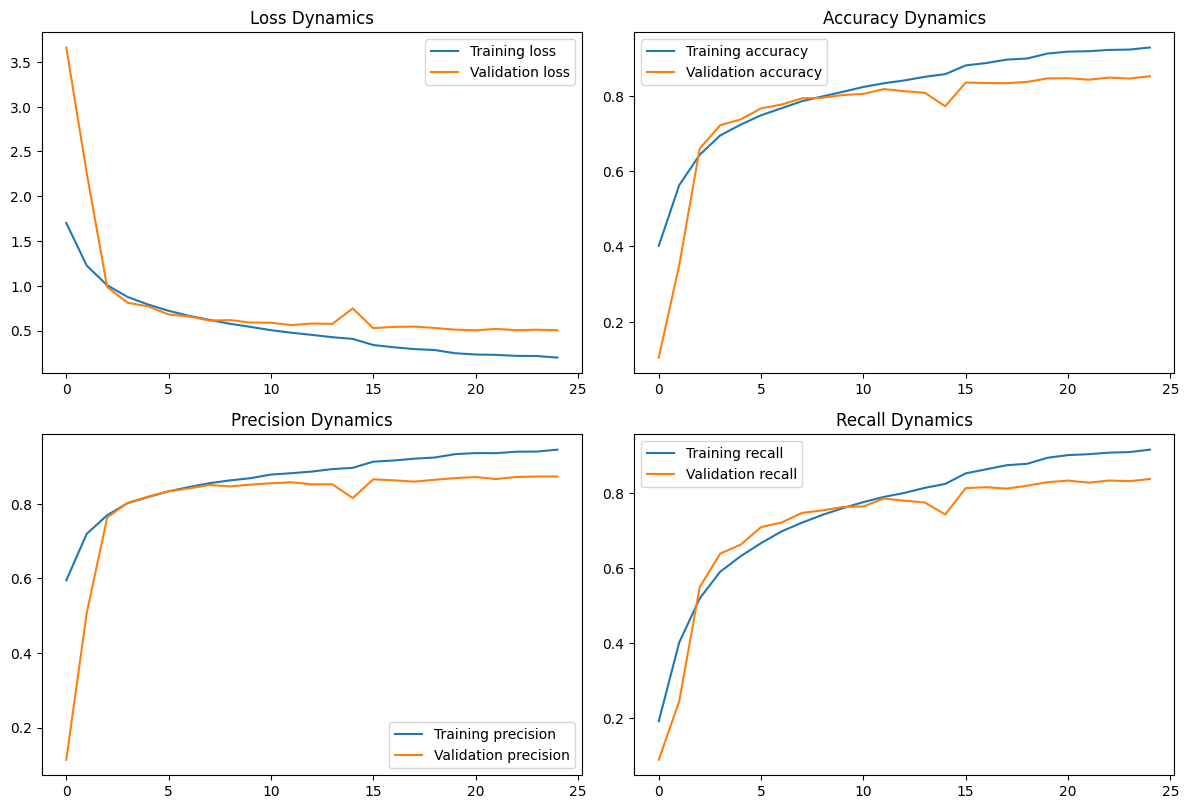

In [6]:
plt.figure(figsize=(12, 16))

subplot_titles = ['Loss', 'Accuracy', 'Precision', 'Recall']
metrics = ['loss', 'accuracy', 'precision', 'recall']
for i, metric in enumerate(metrics, 1):
    plt.subplot(4, 2, i)
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{subplot_titles[i-1]} Dynamics')
    plt.legend()

plt.tight_layout()
plt.show()